# Created a visualizer to help binning balanced samples into each bin
------

## Some background
I joined the Yellowbrick Research Labs (Srping 2018) in District Data Labs as a volunteer recently to create tutorials, walkthroughs and also trouble shooting some of the issues brought up by their uses. One of the project I participated in was initiated by [Rebecca Bilbro](https://rebeccabilbro.github.io/). She was working on dataset from [Pitchfork](https://pitchfork.com/), a music review website and trying to predict the reviewer's score on a piece of music based on the review content. You can check this link to follow her story on music review score prediction: https://rebeccabilbro.github.io/better-binning/

The original scores of the music reviews are numerical, numbers between 0 and 10. Because the high dimention of the text data, she was not able to predict the floating score by using regression. So she decided to bin the scores into 4 categories (“terrible”, “okay”, “great”, and “amazing”). However, the result didn't come back ideal. She found that the unbalanced samples in each bin might be the reason the performance of the model was not as good.

To solve this problem, I decided to create a visualizer to give a reference for binning balanced samples into each bin. Please see the code below for the visualizer:

In [60]:
# yellowbrick.features.histogram
# Implementations of histogram with vertical lines to help with balanced binning.
#
# Author:   Juan L. Kehoe (juanluo2008@gmail.com)
# Created:  Tue Mar 13 19:50:54 2018 -0400
#
# Copyright (C) 2018 District Data Labs
# For license information, see LICENSE.txt
#
# ID: histogram.py

"""
Implements histogram with vertical lines to help with balanced binning.
"""

##########################################################################
## Imports
##########################################################################
import warnings
import matplotlib.pyplot as plt
import numpy as np

from yellowbrick.features.base import FeatureVisualizer
from yellowbrick.exceptions import YellowbrickValueError
from yellowbrick.utils import is_dataframe

##########################################################################
## Balanced Binning Reference
##########################################################################

class BalancedBinningReference(FeatureVisualizer):
    """
    BalancedBinningReference allows to generate a histogram with vertical lines
    showing the recommended value point to bin your data so they can be evenly
    distributed in each bin.

    Parameters
    ----------
    ax: matplotlib Axes, default: None
        This is inherited from FeatureVisualizer and is defined within
        BalancedBinningReference.
    feature: string, default: None
        The name of the X variable
        If a DataFrame is passed to fit and feature is None, feature
        is selected as the column of the DataFrame.  There must be only
        one column in the DataFrame.
    target: string, default: None
        The name of the Y variable
        If target is None and a y value is passed to fit then the target
        is selected from the target vector.
    size: float, default: 600
        Size of each side of the figure in pixels
    ratio: float, default: 5
        Ratio of joint axis size to the x and y axes height
    space: float, default: 0.2
        Space between the joint axis and the x and y axes
    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Examples
    --------
    >>> visualizer = BalancedBinningReference()
    >>> visualizer.fit(X)
    >>> visualizer.poof()


    Notes
    -----
    These parameters can be influenced later on in the visualization
    process, but can and should be set as early as possible.
    """

    def __init__(self, ax=None, feature=None, target='Counts', bins=4,
                 x_args=None, size=600, ratio=5, space=.2, **kwargs):

        super(BalancedBinningReference, self).__init__(ax, **kwargs)

        self.feature = feature
        self.target = target
        self.bins = bins
        self.x_args = x_args
        self.size = (size, size)
        self.ratio = ratio
        self.space = space

    # decide how many bins do you want for your data
    def get_vline_value(self, X):
        """
        Gets the values to draw vertical lines on histogram
        to help balanced binning based on number of bins the
        user wants
        Parameters
        ----------
        X : ndarray or DataFrame of shape n x 1
            A matrix of n instances with 1 feature
        bin: number of bins the user wants, default=4
        """
        # get the number of samples
        samples, = X.shape

        # get the index for retrieving values for the bins
        index = int(round(samples/self.bins))

        # sort the samples from low to high
        sorted_X = np.sort(X)

        # a list to store the values for the binning reference
        values = []

        # get the values for the binning reference
        for i in range(0, (self.bins-1)):
            value = sorted_X[index * (i + 1)]
            values.append(value)

        return np.around(values, decimals=2)

    def draw(self, X, **kwargs):
        """
        Draws a histogram with the reference value for binning as vetical lines
        Parameters
        ----------
        X : ndarray or DataFrame of shape n x 1
            A matrix of n instances with 1 feature
        """

        # draw the histogram
        self.ax.hist(X, bins=50, color="#6897bb", **kwargs)

        # add vetical line with binning reference values
        self.ax.vlines(self.get_vline_value(X), 0, 1, transform=self.ax.get_xaxis_transform(), colors='r')
        print("The binning reference values are:", self.get_vline_value(X))

    def fit(self, X, **kwargs):
        """
        Sets up X for the histogram and checks to
        ensure that X is of the correct data type
        Fit calls draw
        Parameters
        ----------
        X : ndarray or DataFrame of shape n x 1
            A matrix of n instances with 1 feature
        kwargs: dict
            keyword arguments passed to Scikit-Learn API.
        """

        #throw an error if X has more than 1 column
        if is_dataframe(X):
            nrows, ncols = X.shape

            if ncols > 1:
                raise YellowbrickValueError((
                    "X needs to be an ndarray or DataFrame with one feature, "
                    "please select one feature from the DataFrame"
                ))

        # Handle the feature name if it is None.
        if self.feature is None:

            # If X is a data frame, get the columns off it.
            if is_dataframe(X):
                self.feature = X.columns

            else:
                self.feature = ['x']

        self.draw(X)
        return self


    def poof(self, **kwargs):
        """
        Creates the labels for the feature and target variables
        """

        self.ax.set_xlabel(self.feature)
        self.ax.set_ylabel(self.target)
        self.finalize(**kwargs)

    def finalize(self, **kwargs):
        """
        Finalize executes any subclass-specific axes finalization steps.
        The user calls poof and poof calls finalize.
        Parameters
        ----------
        kwargs: generic keyword arguments.
        """

        plt.setp(self.ax.get_xticklabels(), visible=True)
        plt.setp(self.ax.get_yticklabels(), visible=True)


## How to use it
Here I will briefly show you how to use this visulizer to faciliate your binning. 

### First let's generate a dataset with normal distribution

In [61]:
# import packages
import scipy
from scipy.stats import skewnorm
# set random seed
np.random.seed(100)
# generate the normally distributed dataset
norm = skewnorm.rvs(0, size=1000)

### Get the reference value for the binning point for normal distribution

The binning reference values are: [-0.69 -0.03  0.67]


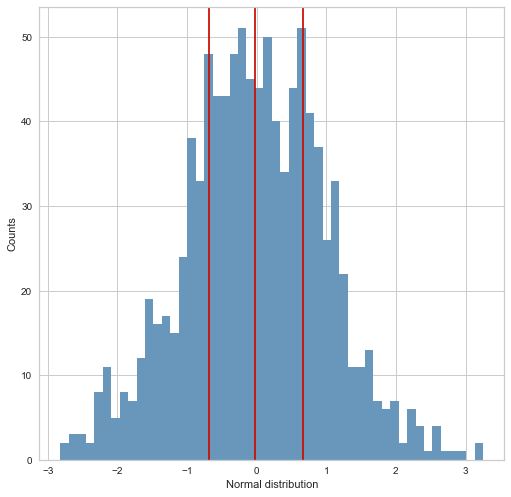

In [62]:
visualizer = BalancedBinningReference(feature="Normal distribution")
visualizer.fit(norm)
visualizer.poof()

### Use the reference value to bin the data

Text(0,0.5,'Counts')

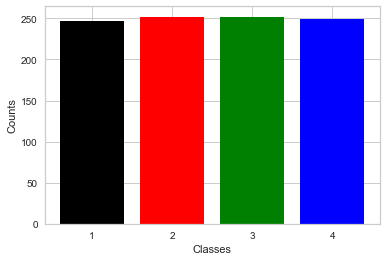

In [75]:
# bin the data based on the reference using numpy.digitize
# set the binning point
# you can copy the binning reference values and paste here
bins = np.array([(norm.min()-0.1), -0.69, -0.03, 0.67, (norm.max()+0.1)]) 
inds = np.digitize(norm, bins,right=True)
counts = np.unique(inds, return_counts=True)[1]

# use matplotlib to view the binned result
plt.bar(["1", "2", "3", "4"], counts, color=['black', 'red', 'green', 'blue'])
plt.xlabel("Classes")
plt.ylabel("Counts")

We can see from the figure above, the amount of binned samples in each class are similar. 

### Change the binning size

The default binning size is 4. You can also change it to the size you need when initializing the visualizer. Here's an example:

The binning reference values are: [-0.94 -0.46 -0.02  0.45  0.92]


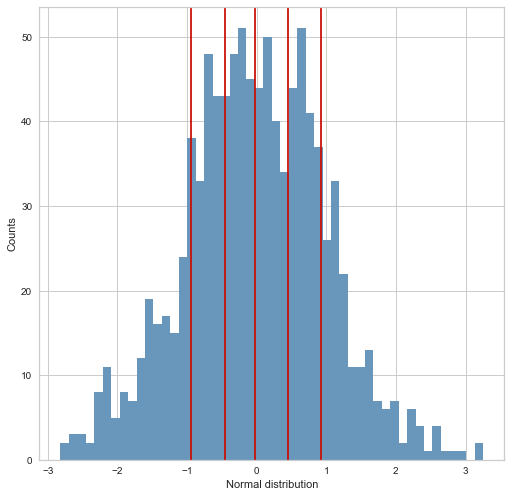

In [74]:
# bin the data into 6 bins
visualizer = BalancedBinningReference(feature="Normal distribution", bins=6)
visualizer.fit(norm)
visualizer.poof()

Text(0,0.5,'Counts')

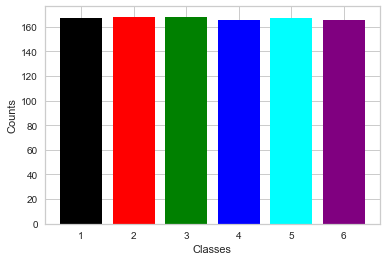

In [77]:
# bin the data based on the reference
bins = np.array([(norm.min()-0.1), -0.94, -0.46, -0.02,  0.45,  0.92, (norm.max()+0.1)]) 
inds = np.digitize(norm, bins,right=True)
counts = np.unique(inds, return_counts=True)[1]

# use matplotlib to view the binned result
plt.bar(["1", "2", "3", "4", "5", "6"], counts, color=['black', 'red', 'green', 'blue', 'cyan', 'purple'])
plt.xlabel("Classes")
plt.ylabel("Counts")

### Bin the data with arbitrary value


Text(0,0.5,'Counts')

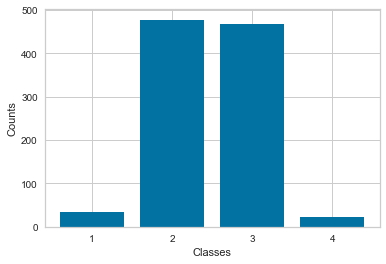

In [68]:
# bin the data without reference
bins = np.array([-3.15, -2, 0, 2, 4.91])
inds = np.digitize(norm, bins)
counts = np.unique(inds, return_counts=True)[1]

# use matplotlib to view the binned result
plt.bar(["1", "2", "3", "4"], counts)
plt.xlabel("Classes")
plt.ylabel("Counts")

As shown above, if we bin the data with a arbitrary value, let's say similar intervals between data points. The number of samples in different classes are so different.

## Use it in skewed data sets

### Bin dataset with right skewness

In [69]:
# generate data with right skewness
right_skew = skewnorm.rvs(-5, size=1000)

The binning reference values are: [-1.14 -0.69 -0.33]


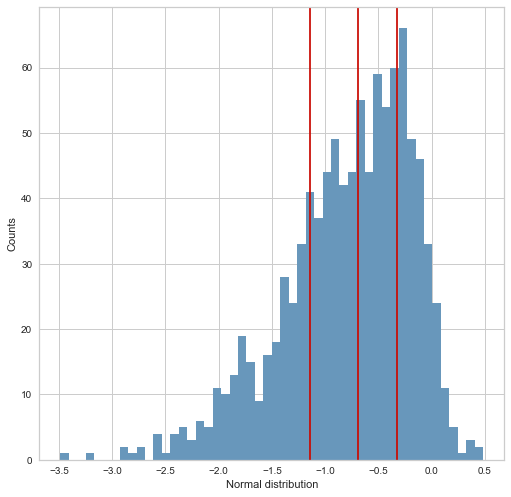

In [72]:
# get the binning reference
visualizer = BalancedBinningReference(feature="Normal distribution")
visualizer.fit(right_skew)
visualizer.poof()

Text(0,0.5,'Counts')

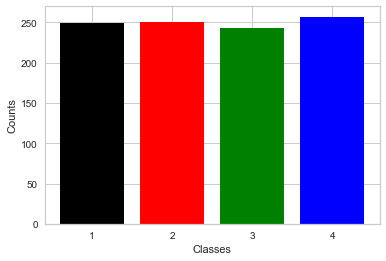

In [78]:
# bin the data based on the reference 
bins = np.array([(right_skew.min()-0.1), -1.14, -0.69, -0.33, (right_skew.max()+0.1)]) 
inds = np.digitize(right_skew, bins,right=True)
counts = np.unique(inds, return_counts=True)[1]

# use matplotlib to view the binned result
plt.bar(["1", "2", "3", "4"], counts, color=['black', 'red', 'green', 'blue'])
plt.xlabel("Classes")
plt.ylabel("Counts")

### Bin dataset with left skewness

The binning reference values are: [0.33 0.69 1.15]


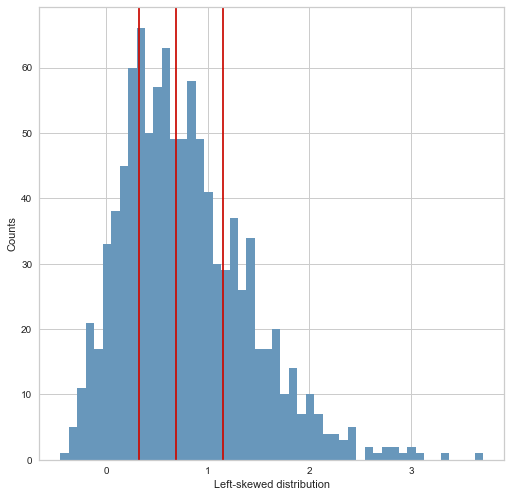

In [79]:
# generate data with left skewness
left_skew = skewnorm.rvs(5, size=1000)

# get the reference value for the binning point for left-skewed distribution
visualizer = BalancedBinningReference(feature="Left-skewed distribution")
visualizer.fit(left_skew)
visualizer.poof()

Text(0,0.5,'Counts')

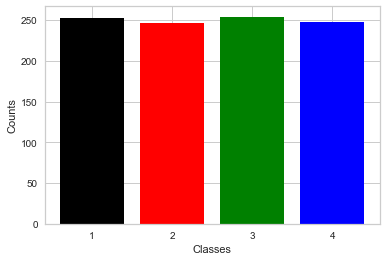

In [81]:
# bin the data based on the reference 
bins = np.array([(left_skew.min()-0.1), 0.33, 0.69, 1.15, (left_skew.max()+0.1)]) 
inds = np.digitize(left_skew, bins,right=True)
counts = np.unique(inds, return_counts=True)[1]

# use matplotlib to view the binned result
plt.bar(["1", "2", "3", "4"], counts, color=['black', 'red', 'green', 'blue'])
plt.xlabel("Classes")
plt.ylabel("Counts")

As we can see that the visualizer did good job on data sets with skewness too. However, if the data is extremely skewed and above 0, you can think of a log transformation on the raw data so it could have better binning result.